In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

In [2]:
directory = Path.cwd()/'Downloads'/'dailydelhiclimate'

train_path = directory/'DailyDelhiClimateTrain.csv'
test_path = directory/'DailyDelhiCLimateTest.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

print('Training Data:')
display(train_data.head())
print('\nTest Data:')
display(train_data.tail())

Training Data:


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000



Test Data:


,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


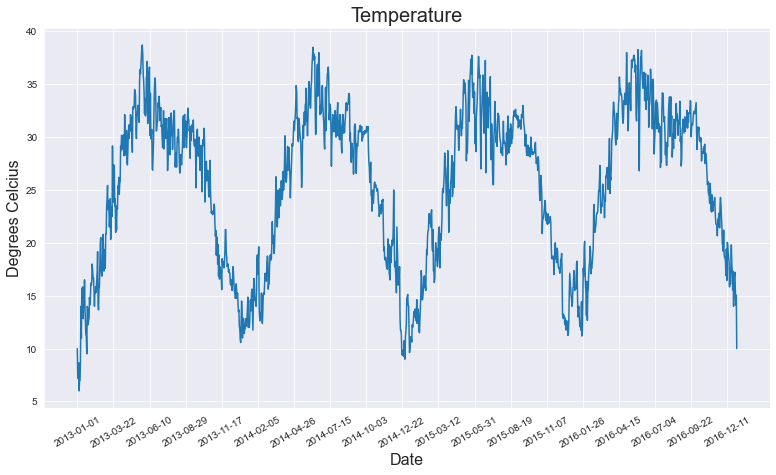

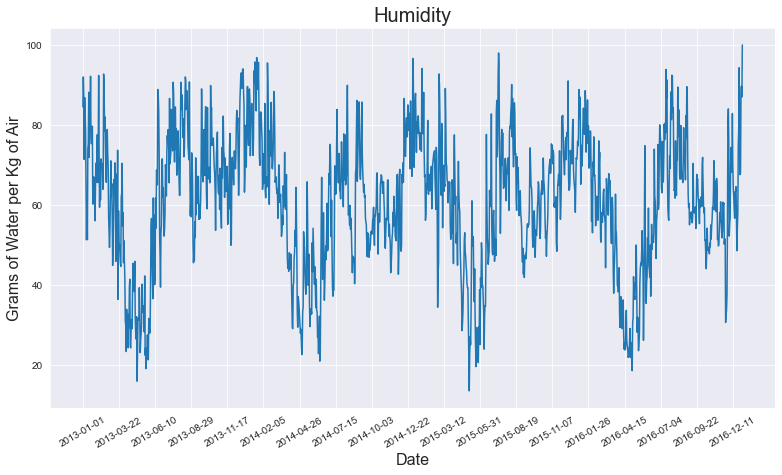

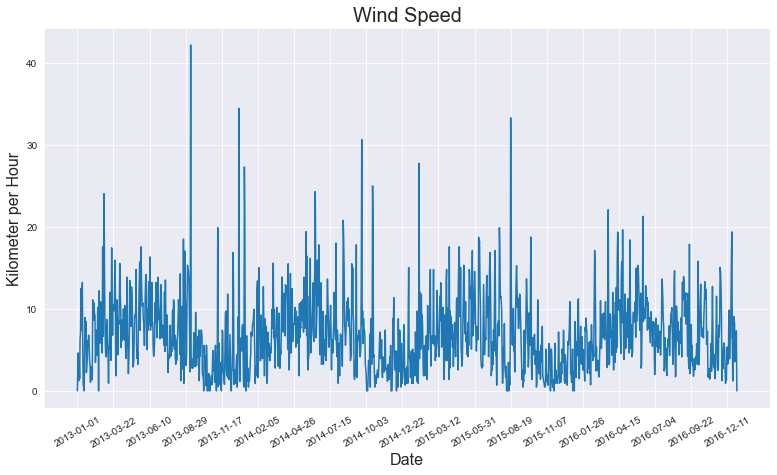

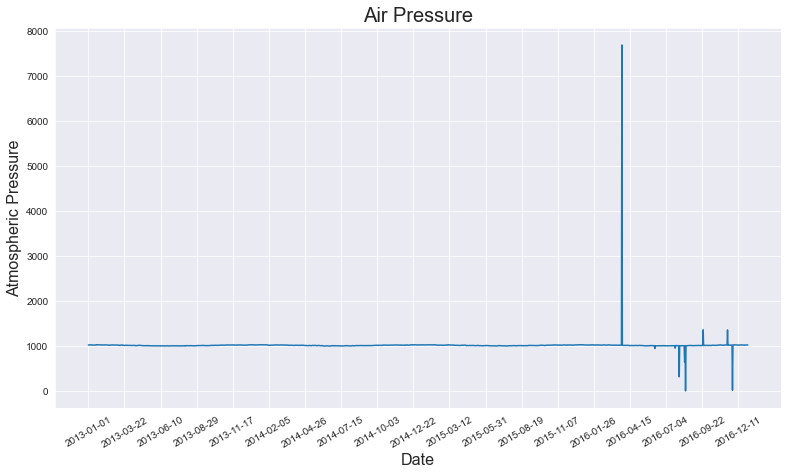

In [3]:
idx = np.array(train_data.index)
idx = train_data['date'][idx%80==0]
figsize=(13,7)
sns.set_style('darkgrid')

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='meantemp')
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Temperature',fontdict={'fontsize':20})
plt.ylabel('Degrees Celcius',fontdict={'fontsize':16})
plt.xticks(idx,rotation=30)
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='humidity')
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Humidity',fontdict={'fontsize':20})
plt.ylabel('Grams of Water per Kg of Air',fontdict={'fontsize':16})
plt.xticks(idx,rotation=30)
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='wind_speed')
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Wind Speed',fontdict={'fontsize':20})
plt.ylabel('Kilometer per Hour',fontdict={'fontsize':16})
plt.xticks(idx,rotation=30)
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='meanpressure')
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Air Pressure',fontdict={'fontsize':20})
plt.ylabel('Atmospheric Pressure',fontdict={'fontsize':16})
plt.xticks(idx,rotation=30)
plt.show()

In [4]:
train_temperature = np.array(train_data.meantemp)
train_length = train_data.shape[0]

x_train_temp = []
y_train_temp = []

temp_feature_size = 25

for i in range(train_length):
    if i >= temp_feature_size:
        start_point = i - temp_feature_size
        x_train_temp.append(train_temperature[start_point:i])
        y_train_temp.append(train_temperature[i])
        
x_train_temp = np.array(x_train_temp)
y_train_temp = np.array(y_train_temp)


test_temperature = np.array(test_data.meantemp)
test_length = test_data.shape[0]

x_test_temp = []
y_test_temp = []

for j in range(test_length):
    if j >= temp_feature_size:
        start_point = j - temp_feature_size
        x_test_temp.append(test_temperature[start_point:j])
        y_test_temp.append(test_temperature[j])
        
x_test_temp = np.array(x_test_temp)
y_test_temp = np.array(y_test_temp)

In [5]:
l1 = keras.regularizers.L1(1)
l2 = keras.regularizers.L2(1)

temperature_model = keras.Sequential([
    keras.layers.Dense(320,input_shape=(temp_feature_size,),activation='relu',kernel_regularizer=l1),
    keras.layers.Dense(320,activation='elu',kernel_regularizer=l2),
    keras.layers.Dense(320,activation='elu',kernel_regularizer=l2),
    keras.layers.Dense(320,activation='elu',kernel_regularizer=l2),
    keras.layers.Dense(320,activation='relu',kernel_regularizer=l2),
    keras.layers.Lambda(lambda x : x*1.4),
    keras.layers.Dense(250,activation='softplus'),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adagrad(learning_rate=.1)

temperature_model.compile(loss='mse',
                         metrics=['mae'],
                         optimizer='adagrad')

temperature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 320)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 320)               102720    
_________________________________________________________________
dense_2 (Dense)              (None, 320)               102720    
_________________________________________________________________
dense_3 (Dense)              (None, 320)               102720    
_________________________________________________________________
dense_4 (Dense)              (None, 320)               102720    
_________________________________________________________________
lambda (Lambda)              (None, 320)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               6

In [6]:
epochs = 2000

temp_history = temperature_model.fit(x_train_temp,
                                     y_train_temp,
                                     validation_data=(x_test_temp,
                                                     y_test_temp),
                                     epochs=epochs,
                                    verbose=False)

temp_hist = temp_history.history

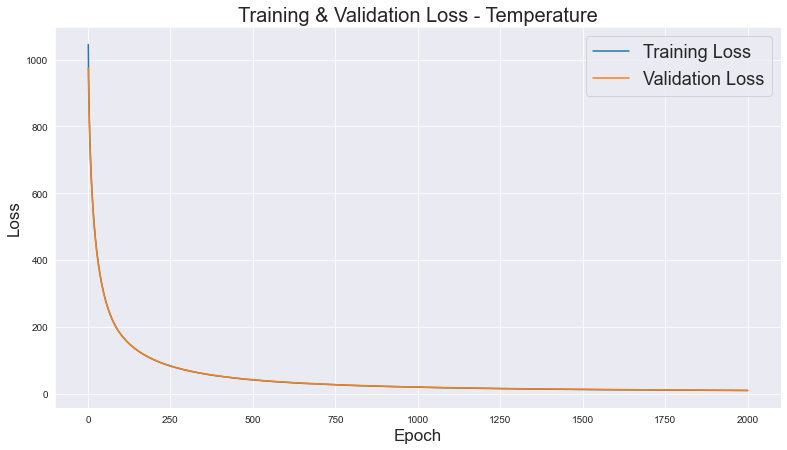

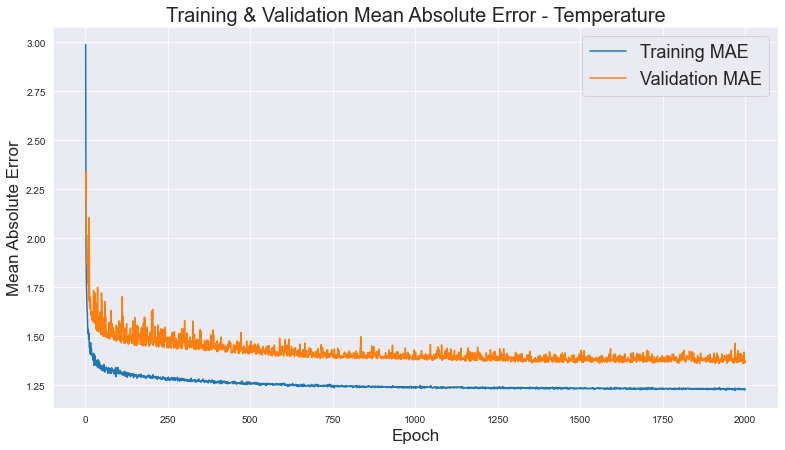

In [7]:
temp_loss = temp_hist['loss']
temp_mae = temp_hist['mae']

val_temp_loss = temp_hist['val_loss']
val_temp_mae = temp_hist['val_mae']

epoch = np.arange(1,epochs+1,1)

plt.figure(figsize=figsize)
plt.plot(epoch,temp_loss)
plt.plot(epoch,val_temp_loss)
plt.title('Training & Validation Loss - Temperature',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Loss',fontdict={'fontsize':17})
plt.legend(['Training Loss','Validation Loss'],prop={'size':18})
plt.show()

plt.figure(figsize=figsize)
plt.plot(epoch,temp_mae)
plt.plot(epoch,val_temp_mae)
plt.title('Training & Validation Mean Absolute Error - Temperature',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Mean Absolute Error',fontdict={'fontsize':17})
plt.legend(['Training MAE','Validation MAE'],prop={'size':18})
plt.show()

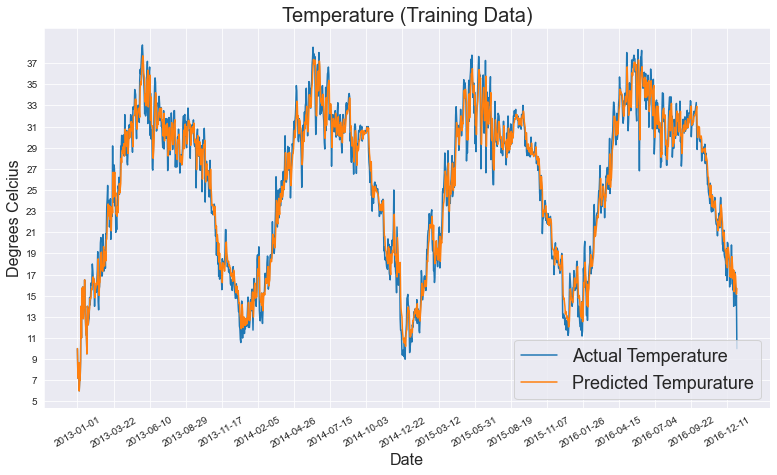

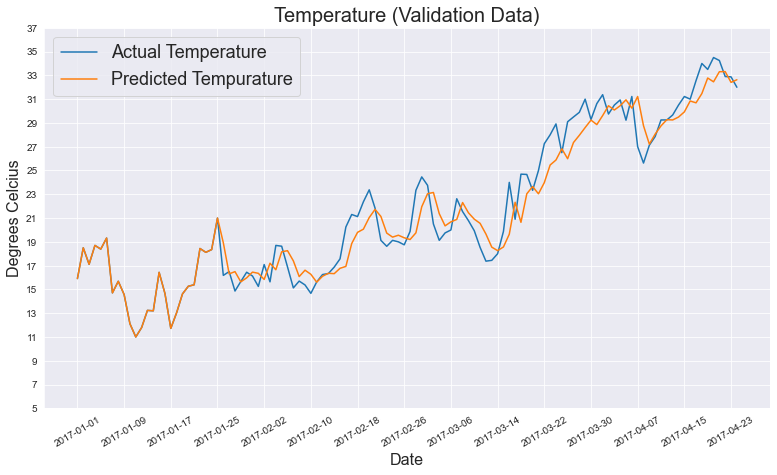

In [8]:
train_temp_predictions = temperature_model.predict(x_train_temp)
train_temp_predictions = np.hstack([train_temperature[:temp_feature_size],train_temp_predictions.squeeze()])

test_temp_predictions = temperature_model.predict(x_test_temp)
test_temp_predictions = np.hstack([test_temperature[:temp_feature_size],test_temp_predictions.squeeze()])

test_idx = np.array(test_data.index)
test_idx = test_data['date'][test_idx%8==0]

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='meantemp')
sns.lineplot(x=train_data['date'],y=train_temp_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Temperature (Training Data)',fontdict={'fontsize':20})
plt.ylabel('Degrees Celcius',fontdict={'fontsize':16})
plt.legend(['Actual Temperature','Predicted Tempurature'],prop={'size':18})
plt.xticks(idx,rotation=30)
plt.yticks(np.arange(5,38,2))
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(data=test_data,x='date',y='meantemp')
sns.lineplot(x=test_data['date'],y=test_temp_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Temperature (Validation Data)',fontdict={'fontsize':20})
plt.ylabel('Degrees Celcius',fontdict={'fontsize':16})
plt.legend(['Actual Temperature','Predicted Tempurature'],prop={'size':18})
plt.xticks(test_idx,rotation=30)
plt.yticks(np.arange(5,38,2))
plt.show()

In [9]:
train_humidity = train_data['humidity']

x_train_humidity = []
y_train_humidity = []

humidity_feature_size = 20

for i in range(train_length):
    if i >= humidity_feature_size:
        start_point = i - humidity_feature_size
        x_train_humidity.append(train_humidity[start_point:i])
        y_train_humidity.append(train_humidity[i])
        
x_train_humidity = np.array(x_train_humidity)
y_train_humidity = np.array(y_train_humidity)

test_humidity = test_data['humidity']

x_test_humidity = []
y_test_humidity = []

for j in range(test_length):
    if j >= humidity_feature_size:
        start_point = j - humidity_feature_size
        x_test_humidity.append(test_humidity[start_point:j])
        y_test_humidity.append(test_humidity[j])
        
x_test_humidity = np.array(x_test_humidity)
y_test_humidity = np.array(y_test_humidity)

In [10]:
l1 = keras.regularizers.L1(1)
l2 = keras.regularizers.L2(1)

humidity_model = keras.Sequential([
    keras.layers.Dense(320,activation='elu',input_shape=(humidity_feature_size,),kernel_regularizer=l1),
    keras.layers.Dense(320,activation='elu',kernel_regularizer=l2),
    keras.layers.Dense(320,activation='elu',kernel_regularizer=l2),
    keras.layers.Dense(320,activation='elu',kernel_regularizer=l2),
    keras.layers.Dense(320),
    keras.layers.LeakyReLU(.1),
    keras.layers.Dense(320),
    keras.layers.LeakyReLU(.1),
    keras.layers.Dense(320,activation='elu',kernel_regularizer=l2),
    keras.layers.Dense(320,activation='relu',kernel_regularizer=l2),
    keras.layers.Dense(1)
])

humidity_model.compile(loss='mse',
                      optimizer='adagrad',
                      metrics=['mae'])

humidity_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 320)               6720      
_________________________________________________________________
dense_8 (Dense)              (None, 320)               102720    
_________________________________________________________________
dense_9 (Dense)              (None, 320)               102720    
_________________________________________________________________
dense_10 (Dense)             (None, 320)               102720    
_________________________________________________________________
dense_11 (Dense)             (None, 320)               102720    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 320)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 320)              

In [11]:
epochs = 2000

humidity_history = humidity_model.fit(x_train_humidity,
                                     y_train_humidity,
                                     validation_data=(x_test_humidity,
                                                     y_test_humidity),
                                     epochs=epochs,
                                     verbose=False)

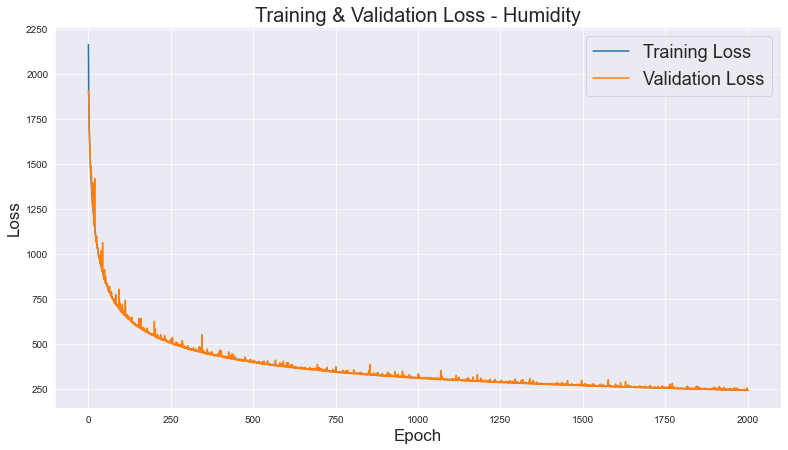

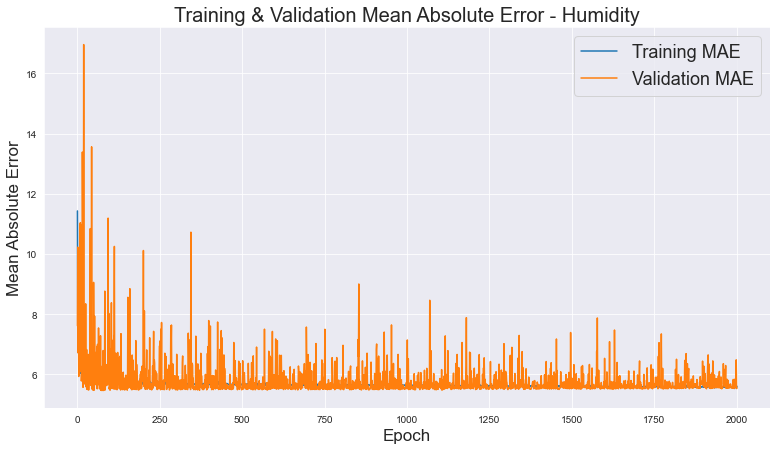

In [12]:
hum_loss = humidity_history.history['loss']
hum_mae = humidity_history.history['mae']

val_hum_loss = humidity_history.history['val_loss']
val_hum_mae = humidity_history.history['val_mae']

epoch = np.arange(1,epochs+1,1)

plt.figure(figsize=figsize)
plt.plot(epoch,hum_loss)
plt.plot(epoch,val_hum_loss)
plt.title('Training & Validation Loss - Humidity',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Loss',fontdict={'fontsize':17})
plt.legend(['Training Loss','Validation Loss'],prop={'size':18})
plt.show()

plt.figure(figsize=figsize)
plt.plot(epoch,hum_mae)
plt.plot(epoch,val_hum_mae)
plt.title('Training & Validation Mean Absolute Error - Humidity',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Mean Absolute Error',fontdict={'fontsize':17})
plt.legend(['Training MAE','Validation MAE'],prop={'size':18})
plt.show()

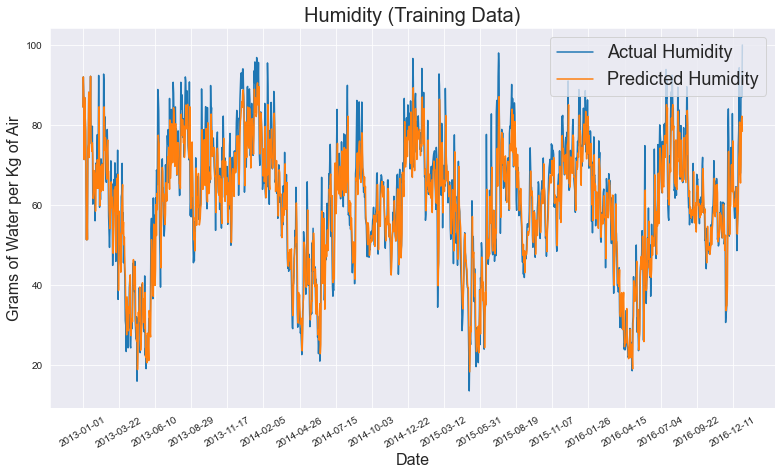

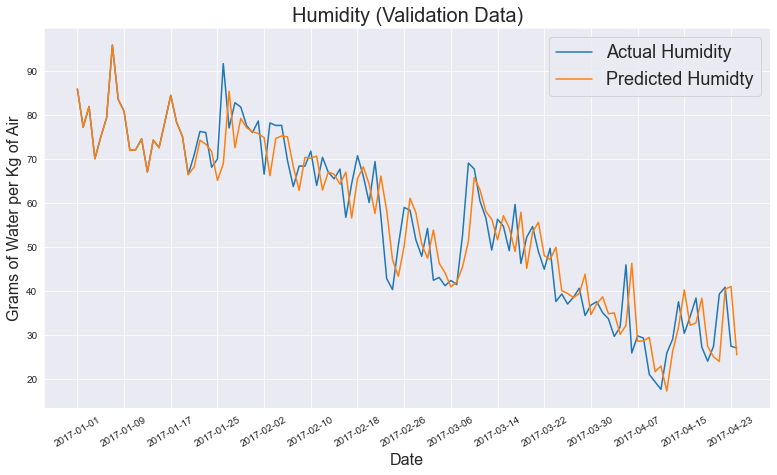

In [13]:
train_hum_predictions = humidity_model.predict(x_train_humidity)
train_hum_predictions = np.hstack([train_humidity[:humidity_feature_size],train_hum_predictions.squeeze()])

test_hum_predictions = humidity_model.predict(x_test_humidity)
test_hum_predictions = np.hstack([test_humidity[:humidity_feature_size],test_hum_predictions.squeeze()])

test_idx = np.array(test_data.index)
test_idx = test_data['date'][test_idx%8==0]

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='humidity')
sns.lineplot(x=train_data['date'],y=train_hum_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Humidity (Training Data)',fontdict={'fontsize':20})
plt.ylabel('Grams of Water per Kg of Air',fontdict={'fontsize':16})
plt.legend(['Actual Humidity','Predicted Humidity'],prop={'size':18})
plt.xticks(idx,rotation=30)
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(data=test_data,x='date',y='humidity')
sns.lineplot(x=test_data['date'],y=test_hum_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Humidity (Validation Data)',fontdict={'fontsize':20})
plt.ylabel('Grams of Water per Kg of Air',fontdict={'fontsize':16})
plt.legend(['Actual Humidity','Predicted Humidty'],prop={'size':18})
plt.xticks(test_idx,rotation=30)
plt.show()

In [14]:
train_wind_speed = train_data['wind_speed']

wind_feature_size = 20

x_train_wind = []
y_train_wind = []

for i in range(train_length):
    if i >= wind_feature_size:
        start_point = i - wind_feature_size
        x_train_wind.append(train_wind_speed[start_point:i])
        y_train_wind.append(train_wind_speed[i])
        
x_train_wind = np.array(x_train_wind)
y_train_wind = np.array(y_train_wind)

test_wind_speed = test_data['wind_speed']

x_test_wind = []
y_test_wind = []

for j in range(test_length):
    if j >= wind_feature_size:
        start_point = j - wind_feature_size
        x_test_wind.append(test_wind_speed[start_point:j])
        y_test_wind.append(test_wind_speed[j])
        
x_test_wind = np.array(x_test_wind)
y_test_wind = np.array(y_test_wind)

In [15]:
l1 = keras.regularizers.L1(.5)
l2 = keras.regularizers.L2(.5)

wind_model = keras.Sequential([
    keras.layers.Dense(350,activation='elu',input_shape=(wind_feature_size,),kernel_regularizer=l1),
    keras.layers.Dense(350,activation='elu',kernel_regularizer=l2),
    keras.layers.Dense(350,activation='elu',kernel_regularizer=l2),
    keras.layers.Dense(350,activation='softplus',kernel_regularizer=l2),
    keras.layers.Dense(350,activation='relu',kernel_regularizer=l2),
    keras.layers.Dense(350,activation='relu',kernel_regularizer=l2),
    keras.layers.Lambda(lambda x : tf.abs(x**1.8)),
    keras.layers.Dense(350,activation='relu',kernel_regularizer=l2),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adagrad(learning_rate=.02)

wind_model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])

wind_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 350)               7350      
_________________________________________________________________
dense_17 (Dense)             (None, 350)               122850    
_________________________________________________________________
dense_18 (Dense)             (None, 350)               122850    
_________________________________________________________________
dense_19 (Dense)             (None, 350)               122850    
_________________________________________________________________
dense_20 (Dense)             (None, 350)               122850    
_________________________________________________________________
dense_21 (Dense)             (None, 350)               122850    
_________________________________________________________________
lambda_1 (Lambda)            (None, 350)              

In [16]:
epochs = 2000

wind_history = wind_model.fit(x_train_wind,
                             y_train_wind,
                             validation_data=(x_test_wind,
                                             y_test_wind),
                             epochs=epochs,verbose=False)

wind_hist = wind_history.history

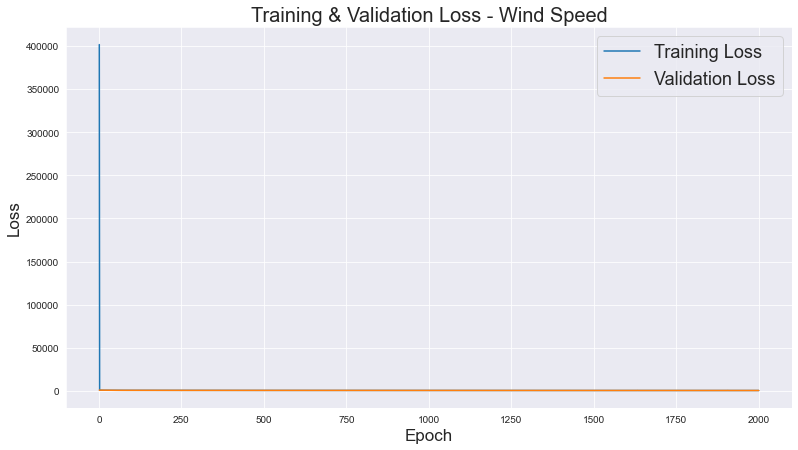

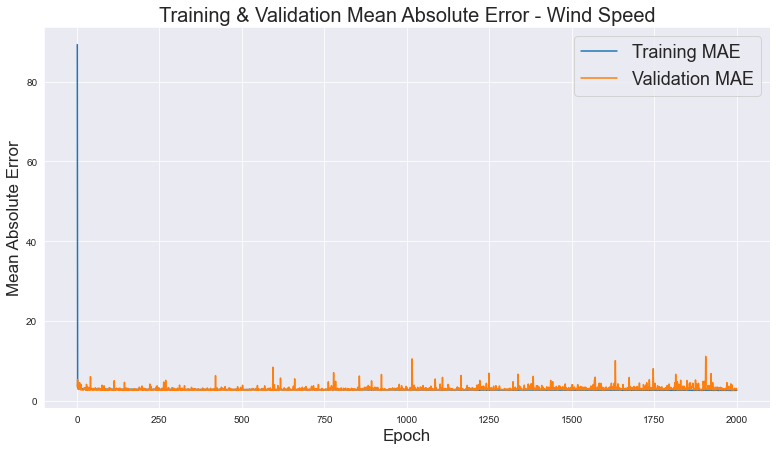

In [17]:
wind_loss = wind_hist['loss']
wind_mae = wind_hist['mae']

val_wind_loss = wind_hist['val_loss']
val_wind_mae = wind_hist['val_mae']

epoch = np.arange(1,epochs+1,1)

plt.figure(figsize=figsize)
plt.plot(epoch,wind_loss)
plt.plot(epoch,val_wind_loss)
plt.title('Training & Validation Loss - Wind Speed',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Loss',fontdict={'fontsize':17})
plt.legend(['Training Loss','Validation Loss'],prop={'size':18})
plt.show()

plt.figure(figsize=figsize)
plt.plot(epoch,wind_mae)
plt.plot(epoch,val_wind_mae)
plt.title('Training & Validation Mean Absolute Error - Wind Speed',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Mean Absolute Error',fontdict={'fontsize':17})
plt.legend(['Training MAE','Validation MAE'],prop={'size':18})
plt.show()

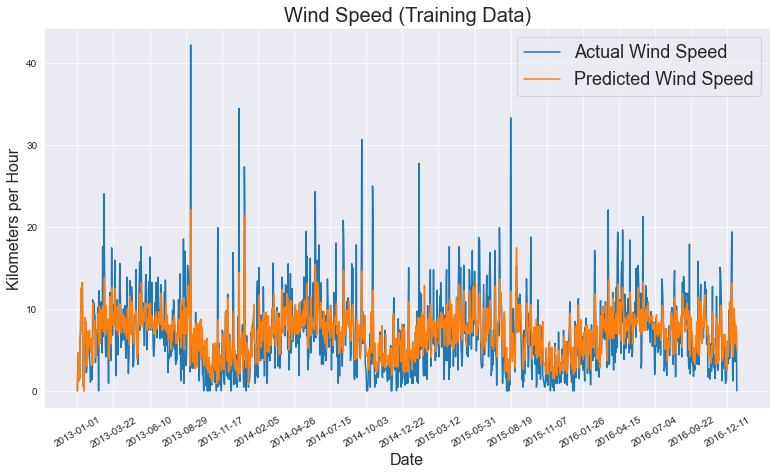

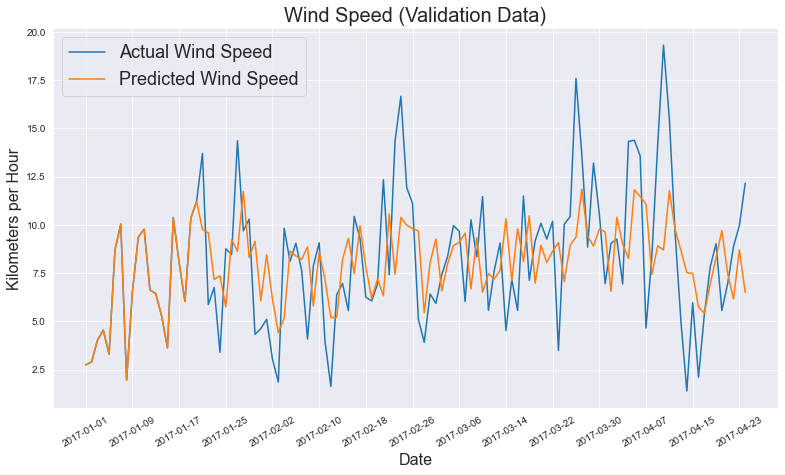

In [18]:
train_wind_predictions = wind_model.predict(x_train_wind)
train_wind_predictions = np.hstack([train_wind_speed[:wind_feature_size],train_wind_predictions.squeeze()])

test_wind_predictions = wind_model.predict(x_test_wind)
test_wind_predictions = np.hstack([test_wind_speed[:wind_feature_size],test_wind_predictions.squeeze()])

test_idx = np.array(test_data.index)
test_idx = test_data['date'][test_idx%8==0]

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='wind_speed')
sns.lineplot(x=train_data['date'],y=train_wind_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Wind Speed (Training Data)',fontdict={'fontsize':20})
plt.ylabel('Kilometers per Hour',fontdict={'fontsize':16})
plt.legend(['Actual Wind Speed','Predicted Wind Speed'],prop={'size':18})
plt.xticks(idx,rotation=30)
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(data=test_data,x='date',y='wind_speed')
sns.lineplot(x=test_data['date'],y=test_wind_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Wind Speed (Validation Data)',fontdict={'fontsize':20})
plt.ylabel('Kilometers per Hour',fontdict={'fontsize':16})
plt.legend(['Actual Wind Speed','Predicted Wind Speed'],prop={'size':18})
plt.xticks(test_idx,rotation=30)
plt.show()

In [19]:
train_air_pressure = train_data['meanpressure']

air_pressure_feature_size = 70

x_train_air = []
y_train_air = []

for i in range(train_length):
    if i >= air_pressure_feature_size:
        start_point = i - air_pressure_feature_size
        x_train_air.append(train_air_pressure[start_point:i])
        y_train_air.append(train_air_pressure[i])
        
x_train_air = np.array(x_train_air)
y_train_air = np.array(y_train_air)

test_air_pressure = test_data['meanpressure']

x_test_air = []
y_test_air = []

for j in range(test_length):
    if j >= air_pressure_feature_size:
        start_point = j - air_pressure_feature_size
        x_test_air.append(test_air_pressure[start_point:j])
        y_test_air.append(test_air_pressure[j])
        
x_test_air = np.array(x_test_air)
y_test_air = np.array(y_test_air)

In [20]:
l1 = keras.regularizers.L1(.4)
l2 = keras.regularizers.L2(.4)

air_model = keras.Sequential([
    keras.layers.Dense(300,activation='elu',input_shape=(air_pressure_feature_size,),kernel_regularizer=l2),
    keras.layers.Dense(300,activation='elu',kernel_regularizer=l2),
    keras.layers.Dense(300,activation='relu',kernel_regularizer=l2),
    keras.layers.Dense(300,activation='relu',kernel_regularizer=l2),
    keras.layers.Dense(1)
])

air_model.compile(loss='mse',
                 optimizer='adagrad',
                 metrics='mae')

air_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 300)               21300     
_________________________________________________________________
dense_25 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_26 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_27 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 301       
Total params: 292,501
Trainable params: 292,501
Non-trainable params: 0
_________________________________________________________________


In [21]:
epochs = 2000

air_history = air_model.fit(x_train_air,
                           y_train_air,
                            validation_data=(x_test_air,
                                            y_test_air),
                           epochs=epochs,
                           verbose=False)

air_hist = air_history.history

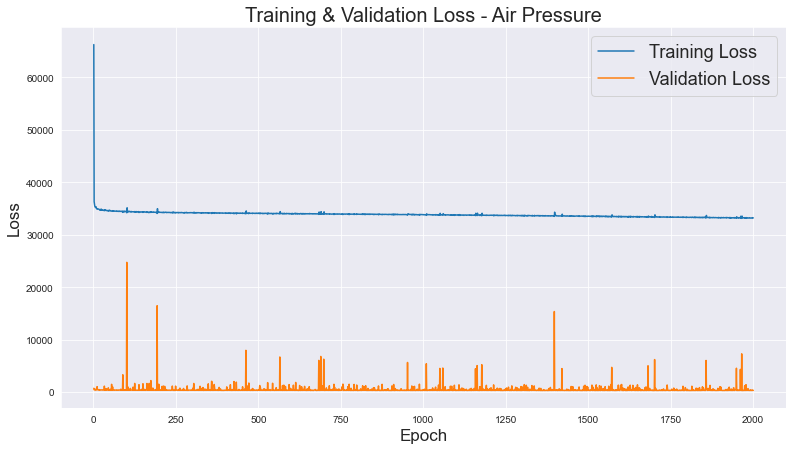

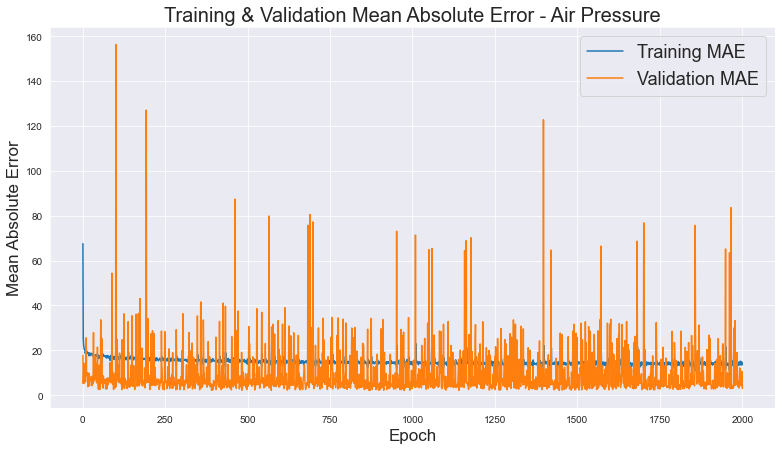

In [22]:
air_loss = air_hist['loss']
air_mae = air_hist['mae']

val_air_loss = air_hist['val_loss']
val_air_mae = air_hist['val_mae']

epoch = np.arange(1,epochs+1,1)

plt.figure(figsize=figsize)
plt.plot(epoch,air_loss)
plt.plot(epoch,val_air_loss)
plt.title('Training & Validation Loss - Air Pressure',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Loss',fontdict={'fontsize':17})
plt.legend(['Training Loss','Validation Loss'],prop={'size':18})
plt.show()

plt.figure(figsize=figsize)
plt.plot(epoch,air_mae)
plt.plot(epoch,val_air_mae)
plt.title('Training & Validation Mean Absolute Error - Air Pressure',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Mean Absolute Error',fontdict={'fontsize':17})
plt.legend(['Training MAE','Validation MAE'],prop={'size':18})
plt.show()

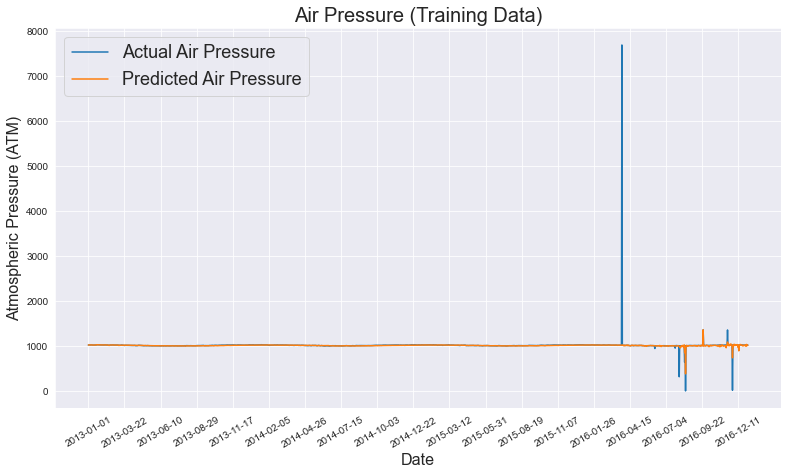

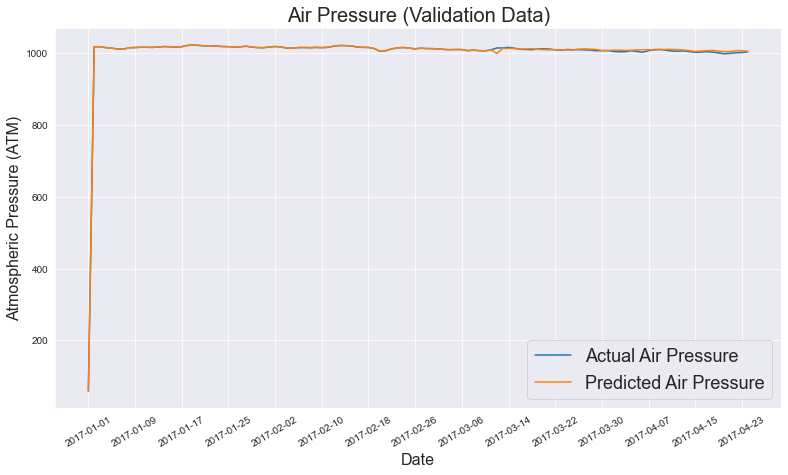

In [23]:
train_air_pressure_predictions = air_model.predict(x_train_air)
train_air_pressure_predictions = np.hstack([train_air_pressure[:air_pressure_feature_size],
                                            train_air_pressure_predictions.squeeze()])

test_air_pressure_predictions = air_model.predict(x_test_air)
test_air_pressure_predictions = np.hstack([test_air_pressure[:air_pressure_feature_size],
                                           test_air_pressure_predictions.squeeze()])

test_idx = np.array(test_data.index)
test_idx = test_data['date'][test_idx%8==0]

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='meanpressure')
sns.lineplot(x=train_data['date'],y=train_air_pressure_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Air Pressure (Training Data)',fontdict={'fontsize':20})
plt.ylabel('Atmospheric Pressure (ATM)',fontdict={'fontsize':16})
plt.legend(['Actual Air Pressure','Predicted Air Pressure'],prop={'size':18})
plt.xticks(idx,rotation=30)
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(data=test_data,x='date',y='meanpressure')
sns.lineplot(x=test_data['date'],y=test_air_pressure_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Air Pressure (Validation Data)',fontdict={'fontsize':20})
plt.ylabel('Atmospheric Pressure (ATM)',fontdict={'fontsize':16})
plt.legend(['Actual Air Pressure','Predicted Air Pressure'],prop={'size':18})
plt.xticks(test_idx,rotation=30)
plt.show()